# Title- Bike Sharing

### Competition Description

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

#### Practice Skills
###### Regression

---
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals


### Overview

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

training set (train.csv)
test set (test.csv)

---
### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime
import calendar
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
 
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)
sns.set(style="white", color_codes=True)

In [2]:
load_app_config()
DIRECTORY="bike_sharing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'count'
input_path = get_datafolder_path()

Adding F:\MachineLearning  to system path
Adding F:\DataSource  to system path


In [3]:
def load_dataset(filename=TRAIN_FILE,response=RESPONSE):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = pd.read_csv(input_file,parse_dates=True)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns.values.tolist()
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns.values.tolist()
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response == col]
    feature_columns =  [col for col in input_dataset.columns if response != col]
      
    return  input_dataset,feature_columns,response_column,continuous_vars,categorical_vars


In [4]:
train_dataset,feature_columns,response_column,continuous_vars,categorical_vars = load_dataset(filename=TRAIN_FILE,response=RESPONSE)
test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars  = load_dataset(filename=TEST_FILE,response=RESPONSE)



 input file is :F:\DataSource\bike_sharing\train.csv loaded.
Continous Variables
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
Categorical Variables
['datetime']
 input file is :F:\DataSource\bike_sharing\test.csv loaded.
Continous Variables
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
Categorical Variables
['datetime']


In [5]:

def create_features(dataset):
    dataset["datetime_tmp"] = pd.to_datetime(dataset["datetime"])
    dataset['year'] = dataset['datetime_tmp'].dt.year
    dataset['month'] = dataset['datetime_tmp'].dt.month
    dataset['day'] = dataset['datetime_tmp'].dt.day
    dataset['hour'] = dataset['datetime_tmp'].dt.hour
    dataset['minute'] = dataset['datetime_tmp'].dt.minute
    dataset["weekday"] = dataset["datetime_tmp"].apply(lambda date : calendar.day_name[date.weekday()])
    dataset["month"] = dataset["datetime_tmp"].apply(lambda date : calendar.month_name[date.month])
    return dataset

train_dataset  = create_features(train_dataset)
test_dataset = create_features(test_dataset)


### Outliers Analysis

In [6]:
 
from collections import Counter
def detect_outliers(dataset,noutliers,columns):
    outlier_indices = []
    for column in columns:
        # 1st quartile (25%),# 3rd quartile (75%)
        q1, q3 = np.percentile(dataset[column], [25, 75])
         
       # Interquartile range (IQR)
        iqr = q3 - q1
        
        # outlier step
        outlier_step = 1.5 * iqr
        
        lower_bound = q1 - outlier_step
        upper_bound = q3 + outlier_step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataset[(dataset[column] < lower_bound ) | (dataset[column] > upper_bound )].index
        outlier_indices.extend(outlier_list_col)
         
    outlier_indices = Counter(outlier_indices)
     
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > noutliers )
    
    return multiple_outliers 
outliers_to_drop = detect_outliers(train_dataset,2,["count"])
print(train_dataset.loc[outliers_to_drop])
print("Before dropping outliers  :{0}" .format(train_dataset.shape))
train_dataset = train_dataset.drop(outliers_to_drop, axis = 0).reset_index(drop=True)
print("After dropping outliers  :{0}" .format(train_dataset.shape))

Empty DataFrame
Columns: [datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, datetime_tmp, year, month, day, hour, minute, weekday]
Index: []
Before dropping outliers  :(10886, 19)
After dropping outliers  :(10886, 19)


---
### 2.Summarize Data 
#### a) Descriptive statistics
#### b) Data visualizations

In [7]:
sort_order  = train_dataset['month'].unique()
sort_order =list(sort_order)
week_order =train_dataset['weekday'].unique()
week_order =list(week_order)

In [8]:
def display_data_descriptives(input_dataset,feature_columns,response_column):
    print("<{0} {1} {0}>".format("="*40,"info"))
    print(input_dataset.info())
    print("<{0} {1} {0}>".format("="*40,"feature columns"))
    print(feature_columns)
    print("<{0} {1} {0}>".format("="*40,"response"))
    print(response_column)
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -X"))
    print(input_dataset[feature_columns].describe())
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -y"))
    print(input_dataset[response_column].describe())
    #print("<{0} {1} {0}>".format("="*40,"value_count -y"))
 
    #print(y.groupby(response_column)[response_column].count())
    
pd.set_option('display.width', 120)
pd.set_option('precision', 4)
display_data_descriptives(train_dataset,feature_columns,response_column)
#display_data_descriptives(test_dataset,tfeature_columns,tresponse_column,tcontinuous_vars,tcategorical_vars)
print(test_dataset.info())
print("<{0} {1} {0}>".format("="*40,"train data header"))
train_dataset.head() 

<======================================== info ========================================>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
datetime        10886 non-null object
season          10886 non-null int64
holiday         10886 non-null int64
workingday      10886 non-null int64
weather         10886 non-null int64
temp            10886 non-null float64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
casual          10886 non-null int64
registered      10886 non-null int64
count           10886 non-null int64
datetime_tmp    10886 non-null datetime64[ns]
year            10886 non-null int64
month           10886 non-null object
day             10886 non-null int64
hour            10886 non-null int64
minute          10886 non-null int64
weekday         10886 non-null object
dtypes: datetime64[ns](1), float64(3), int64(12), object(3)
memory usage: 1.6+ MB

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_tmp,year,month,day,hour,minute,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,January,1,0,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,January,1,1,0,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,January,1,2,0,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,January,1,3,0,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,January,1,4,0,Saturday


### Univariate plots 

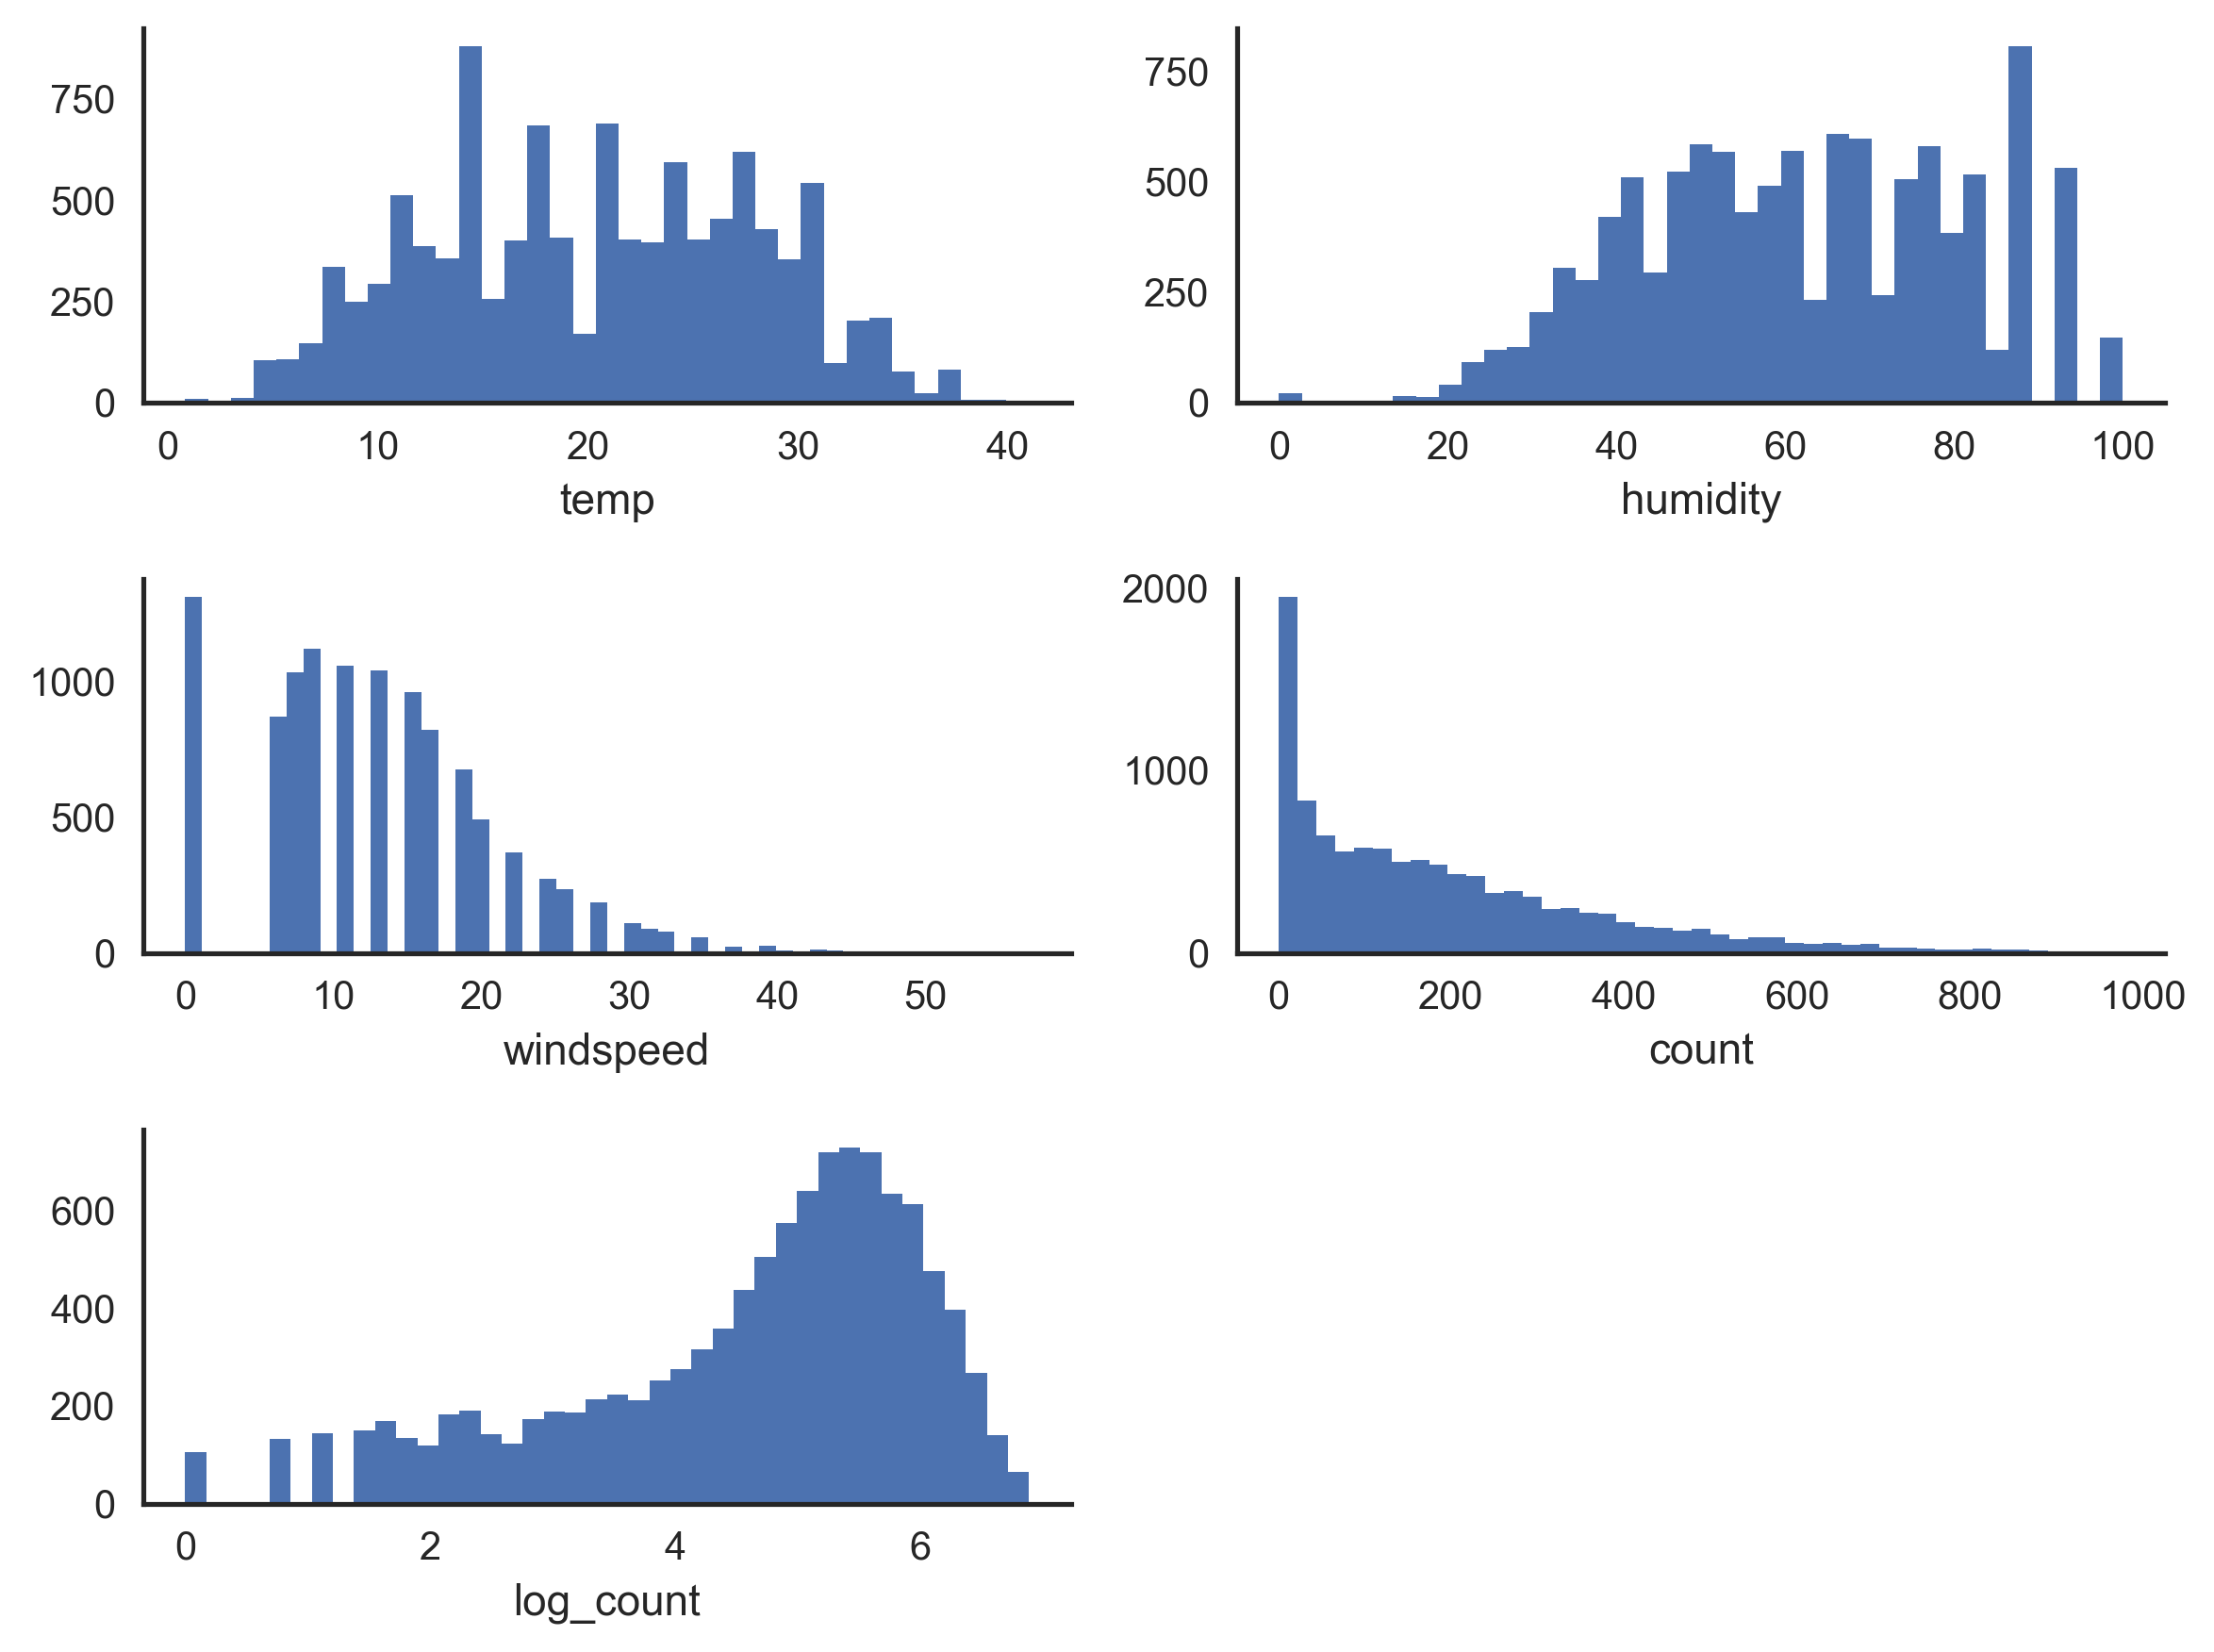

In [9]:
train_dataset['log_count'] =  np.log(train_dataset['count'])
continuous_features =['temp', 'humidity', 'windspeed','count','log_count']
def dist_plots(train_dataset,continuous_features):
    fig = plt.figure(figsize=(8,6),dpi=300)
    size =len(continuous_features)
     
    for i in range(size):
        ax = fig.add_subplot(3, 2, i+1)
        sns.distplot(train_dataset[train_dataset[continuous_features[i]].notnull()][continuous_features[i]],ax=ax ,
                     kde =False,hist_kws=dict(alpha=1))
        sns.despine()
    plt.tight_layout()
    plt.show()
dist_plots(train_dataset,continuous_features)

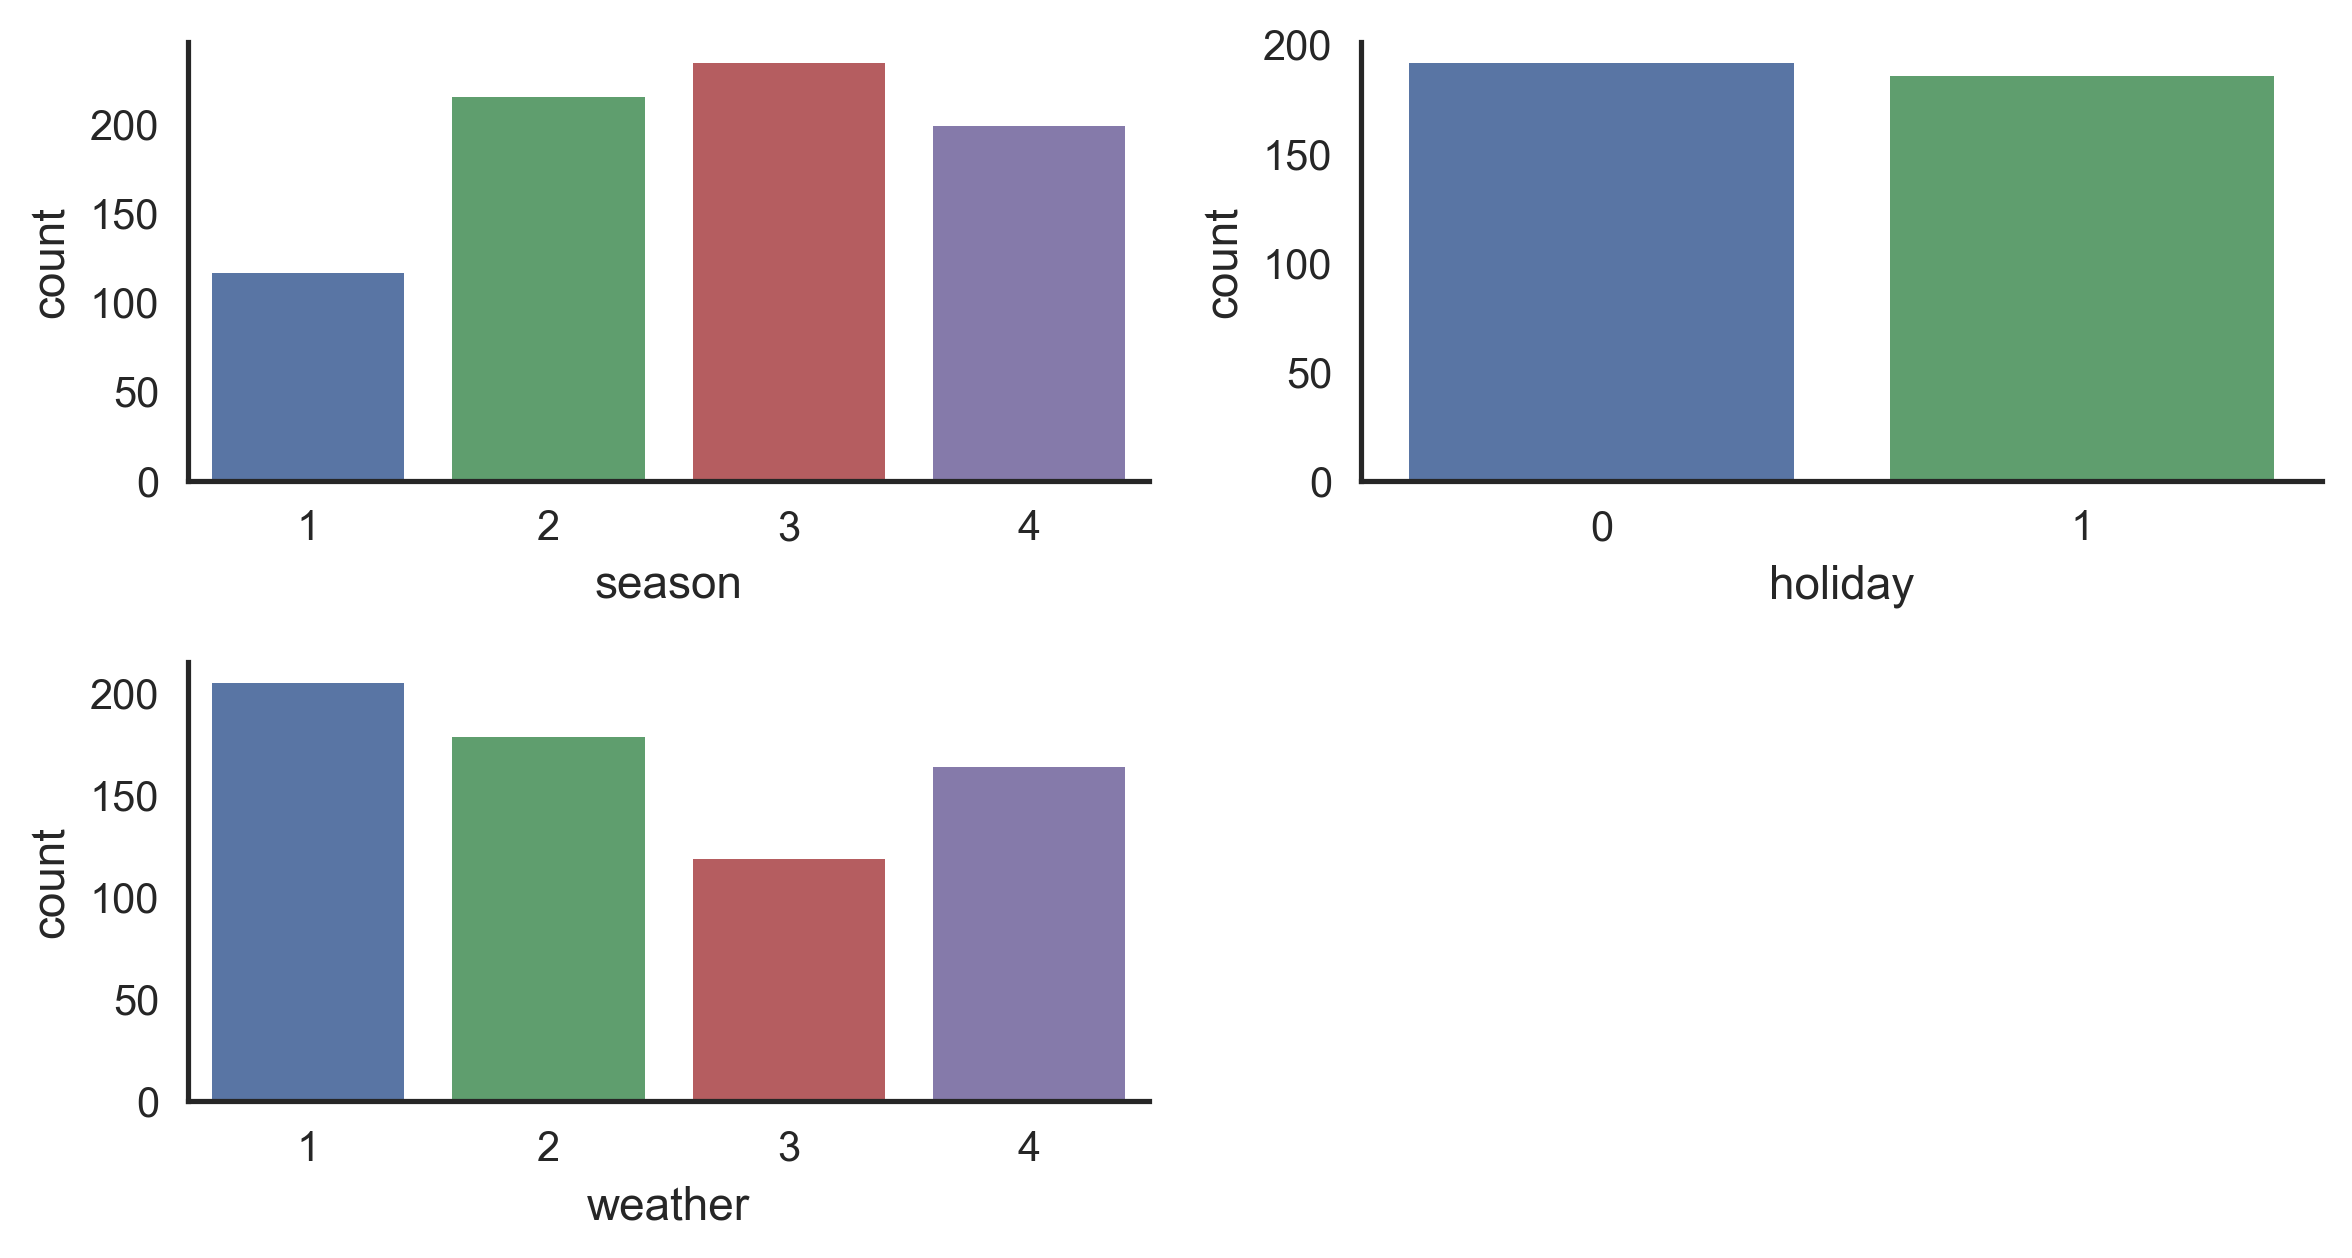

In [10]:
categorical =['season','holiday','weather']
def count_plots(train_dataset,categorical):
    fig = plt.figure(figsize=(8,6),dpi=300)
    size =len(categorical)
     
    for i in range(size):
        ax = fig.add_subplot(3, 2, i+1)
        sns.barplot(x=categorical[i],y="count" ,data=train_dataset,ax=ax,ci=None)
        sns.despine()
    plt.tight_layout()
    plt.show()
count_plots(train_dataset,categorical)

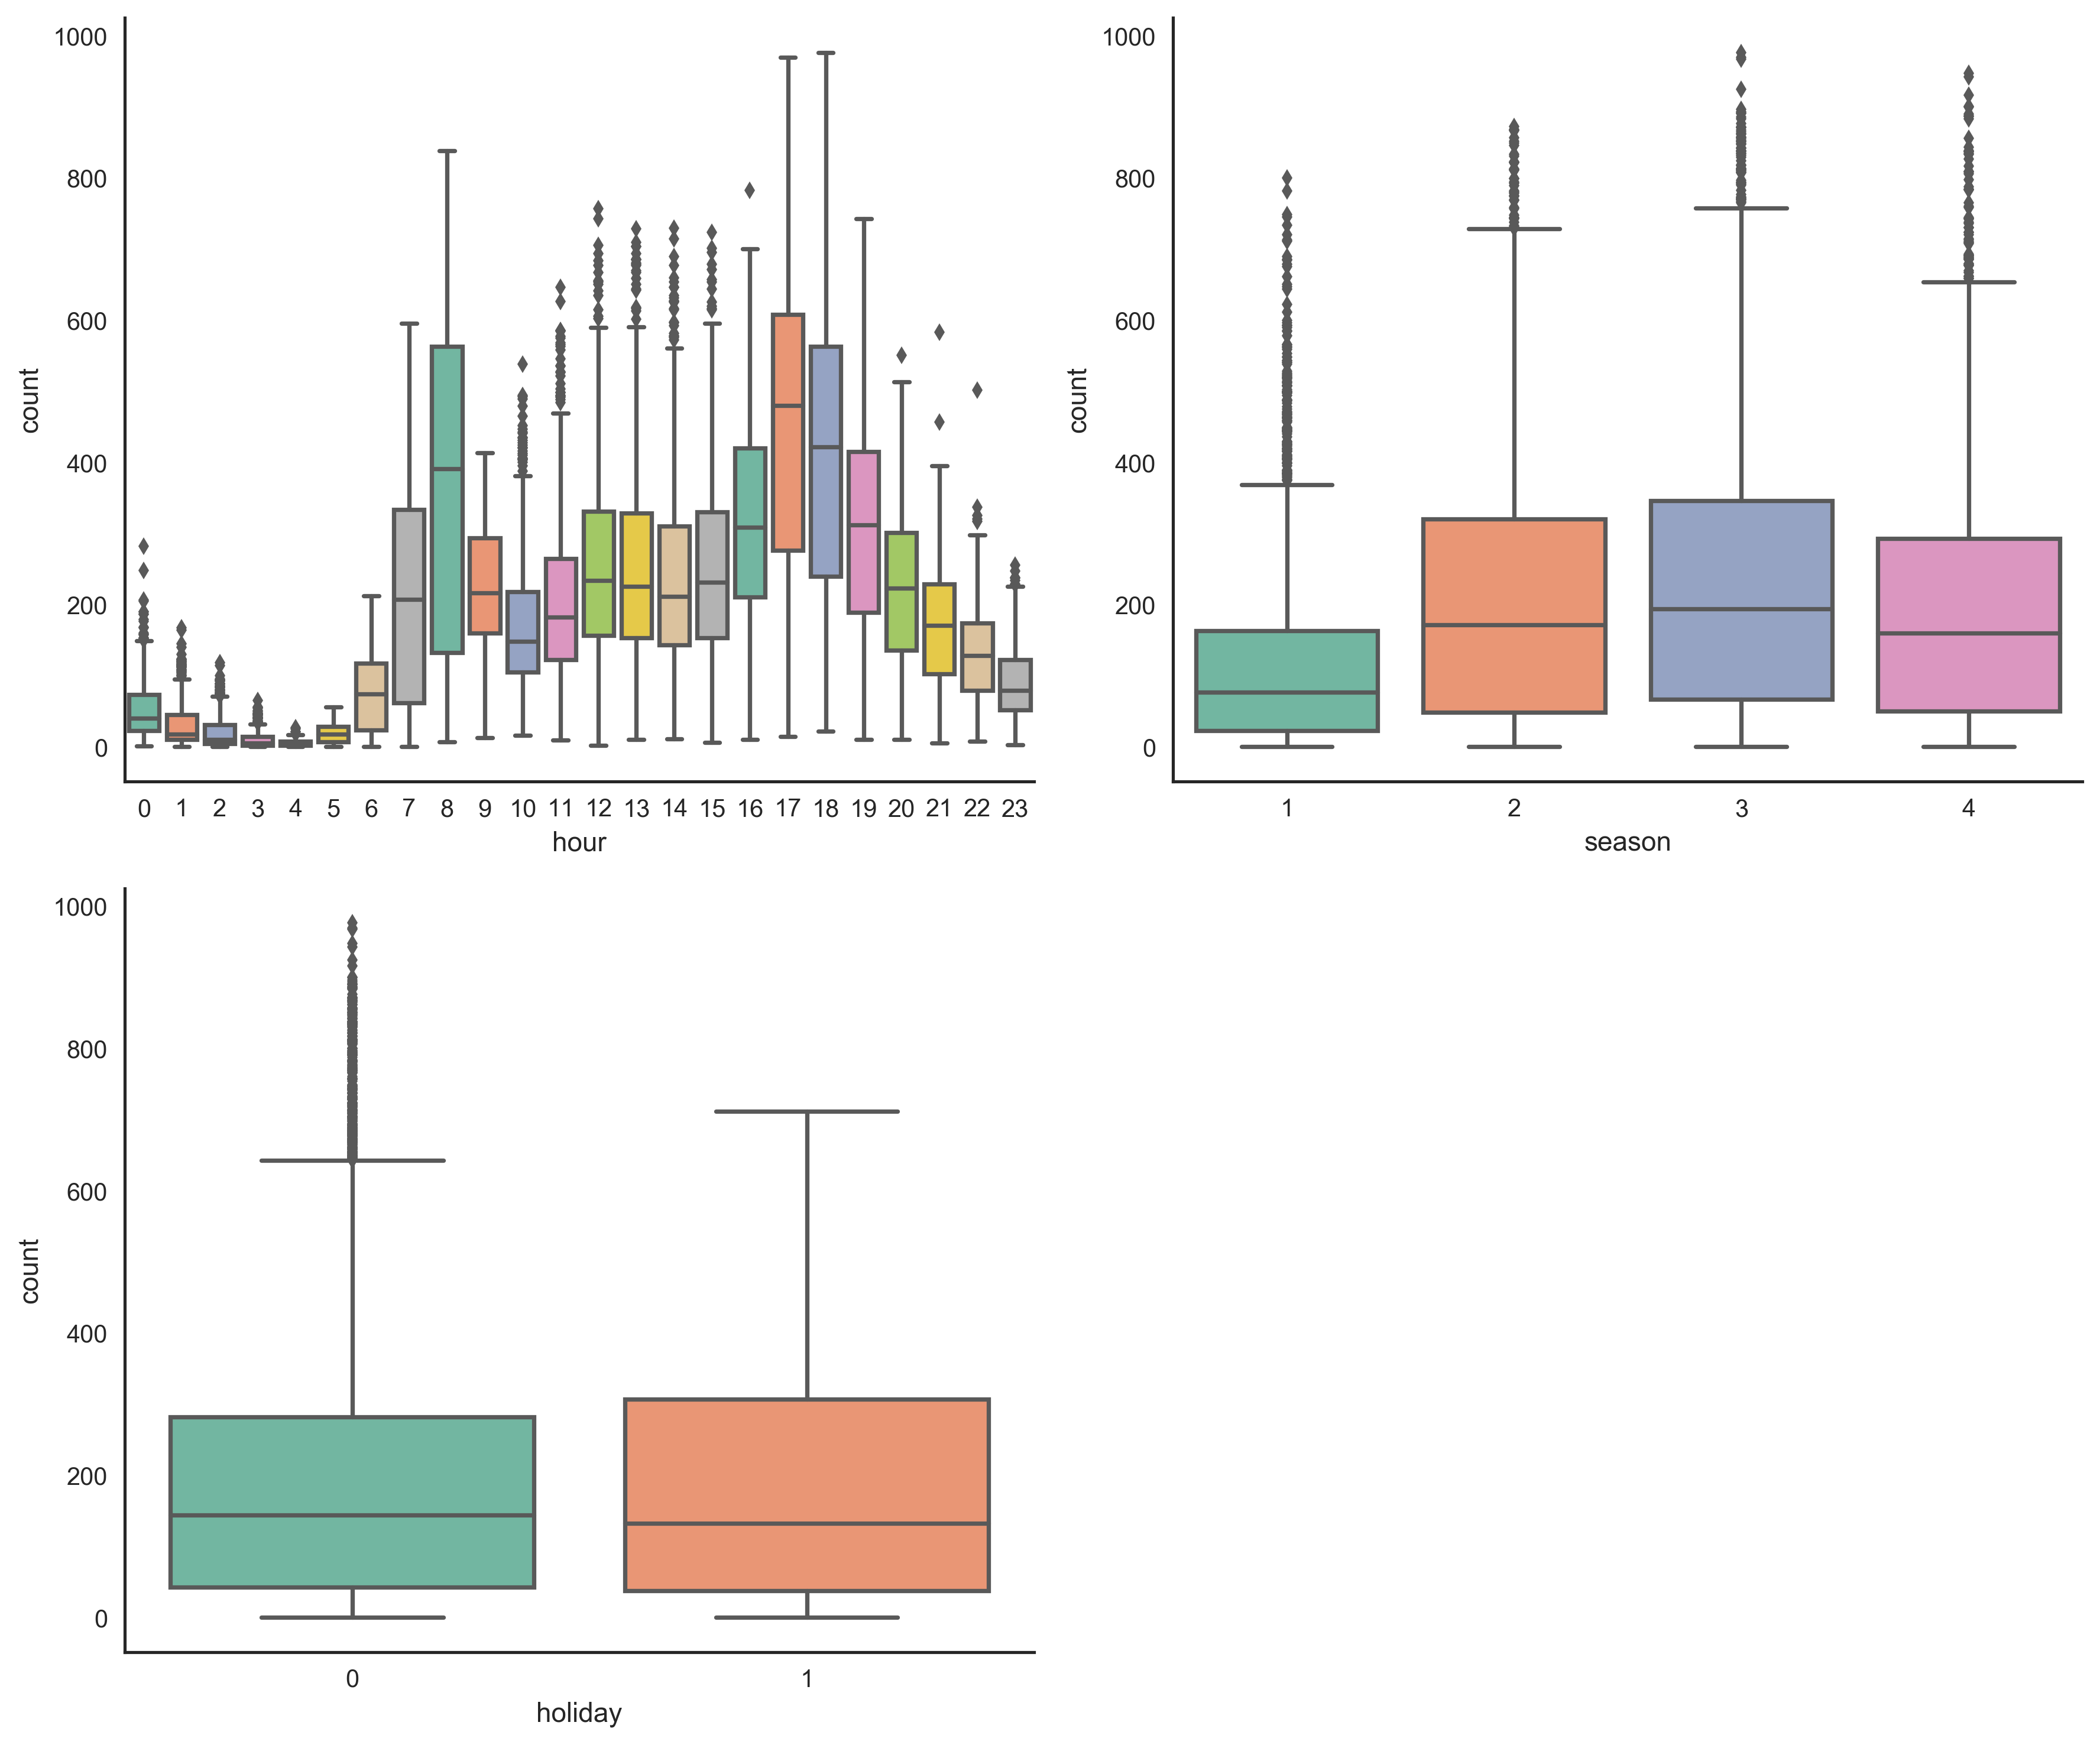

In [11]:
box_features =['hour','season','holiday']
def box_plots(train_dataset,feature_columns):
    fig = plt.figure(figsize=(12,10),dpi=300)
    size =len(feature_columns)
     
    for i in range(size):
        ax = fig.add_subplot(2,2, i+1)
        sns.boxplot(x=feature_columns[i],y="count" ,data=train_dataset,ax=ax,palette="Set2",orient="v")
        ax.set_xticklabels(ax.get_xticklabels())
        sns.despine()
    plt.tight_layout()
    plt.show()
box_plots(train_dataset,box_features)

### Inferences 
#### season 1  has low  demand for bikes 
#### weather 3  has low demand for bikes
#### Non holidays have slighlty more demand  than holidays
####  Based on hour-count plot , looks like in a day  there are peak hours and off peak hours. we need create bins based on hours 

#### High       : 7-9 and 17-19 hours
#### Average  : 10-16 hours
#### Low         : 0-6 and 20-24 hours

### Bi-variate Analysis
#### scatter plots , bar plots

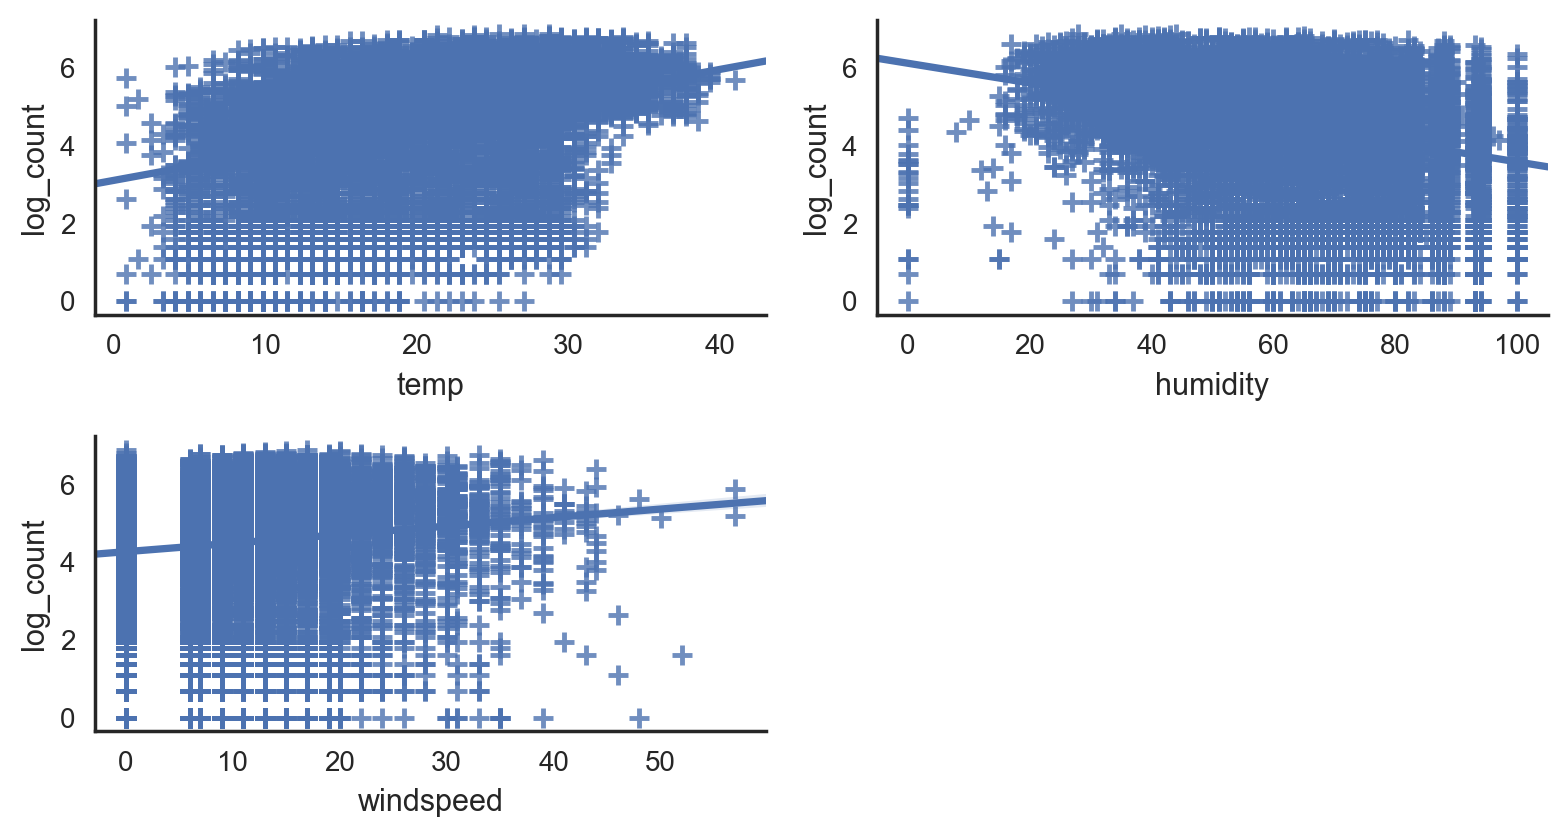

In [12]:
scatter_features =['temp', 'humidity', 'windspeed']
def scatter_plots(train_dataset,scatter_features,response_column):
    fig = plt.figure(figsize=(8,6),dpi=200)
    size =len(scatter_features)
     
    for i in range(size):
        ax = fig.add_subplot(3, 2, i+1)
        sns.regplot( data =train_dataset,y=response_column,x= scatter_features[i],marker='+' )
        sns.despine()
    plt.tight_layout()
    plt.show()
scatter_plots(train_dataset,scatter_features,'log_count')

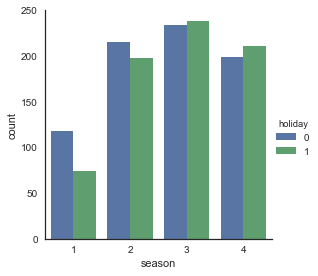

In [13]:
g = sns.factorplot(x="season", y="count", hue="holiday", data=train_dataset , kind="bar",ci=None) 

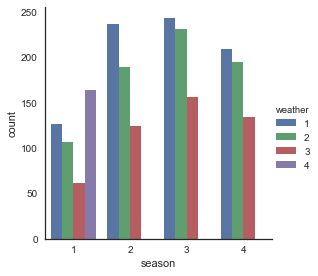

In [14]:
g = sns.factorplot(x="season", y="count", hue="weather", data=train_dataset ,kind="bar", ci=None)  

#### weather 1 ,2   have good demand across all  seasons

In [15]:
feature_columns =["temp","atemp","casual","registered","humidity","windspeed"]
def plot_heatmap(input_dataset,feature_columns,response_column):
    
    sns.set(font_scale=1.5)
    cm=input_dataset[feature_columns+response_column].corr('pearson')
    mask = np.array(cm)
    mask[np.tril_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(20,10))
    hm = sns.heatmap(cm,cbar=True,mask = mask,annot=True,square=True,annot_kws={'size': 15},
                     yticklabels=feature_columns+response_column,xticklabels=feature_columns+response_column)
    plt.show()

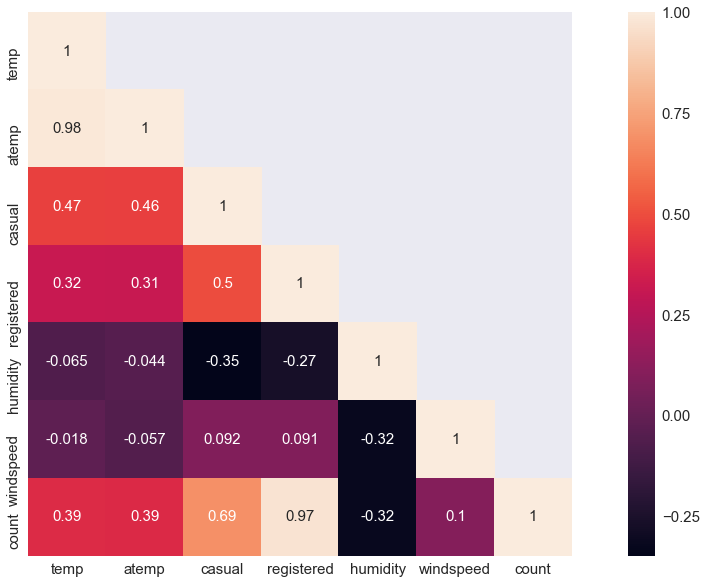

In [16]:
plot_heatmap(train_dataset,feature_columns,response_column)

In [17]:
train_dataset.columns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

#### Trend of bikesharing  on weekdays 
##### which day has maximum demand  ?
##### By looking at the below histogram looks like Saturday seems to have some edge over other days

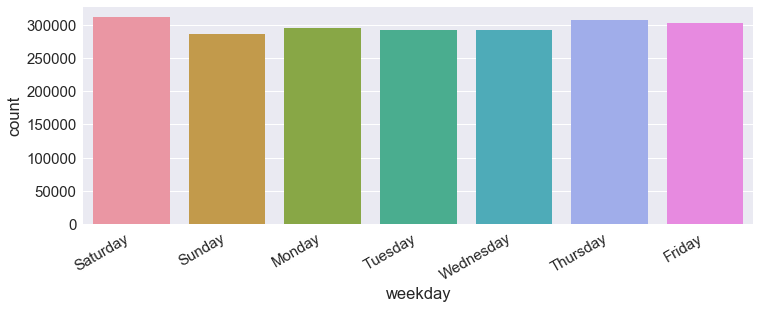

In [18]:
groupby_day =  pd.DataFrame(train_dataset.groupby(["weekday"])["count"].sum()).reset_index()
groupby_day = groupby_day.sort_values(by="count",ascending=False)
f, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=groupby_day,x="weekday",y="count",order=week_order,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
sns.despine()

#### Trend of bike sharing  based on seasons

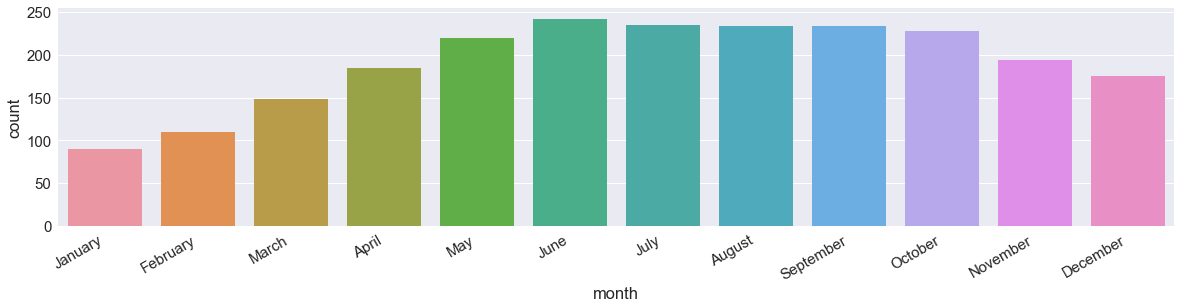

In [19]:
groupby_month = pd.DataFrame(train_dataset.groupby(["month"])["count"].mean()).reset_index()
monthSorted = groupby_month.sort_values(by="count",ascending=False)
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(data=monthSorted,x="month",y="count",order=sort_order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
sns.despine()

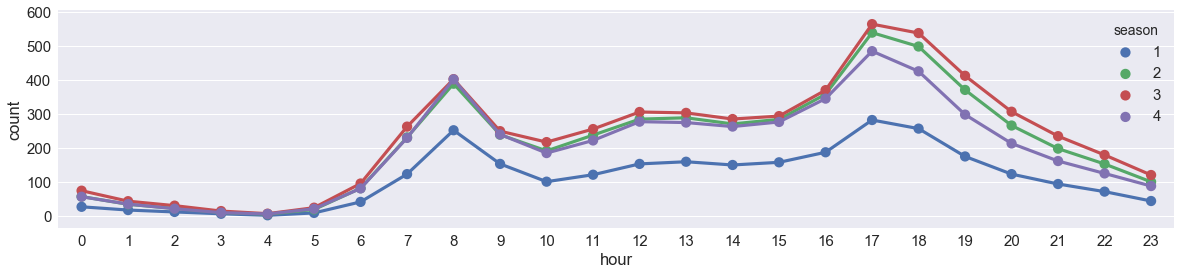

In [20]:
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1.5)
groupby_season_hour = pd.DataFrame(train_dataset.groupby(["season","hour"])["count"].mean()).reset_index()
#hourSorted = groupby_season_hour.sort_values(by="count",ascending=False)
f, ax = plt.subplots(figsize=(20,4))
sns.pointplot(data=groupby_season_hour,x="hour",y="count" ,hue ="season" ,ax=ax  ,join=True)
sns.despine()
 

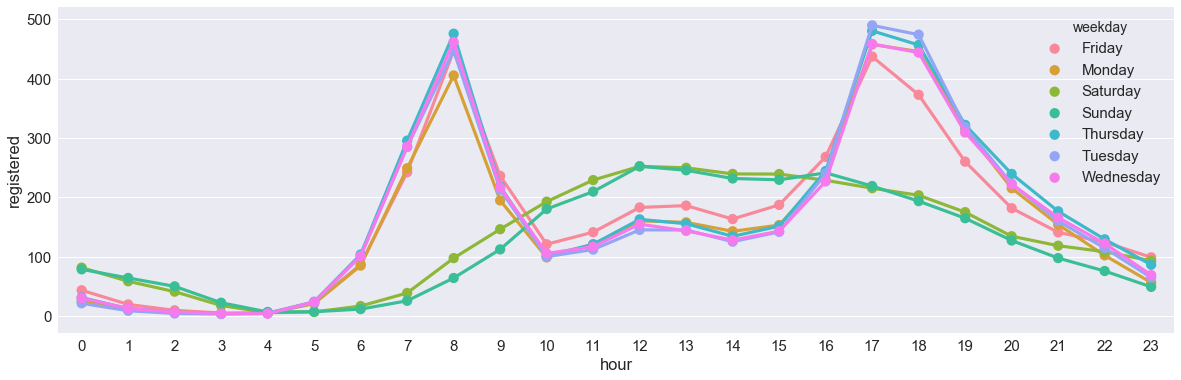

In [21]:
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1.5)
groupby_weekday_hour = pd.DataFrame(train_dataset.groupby(["weekday","hour"])["registered"].mean()).reset_index()
f, ax = plt.subplots(figsize=(20, 6))
sns.pointplot(data=groupby_weekday_hour,x="hour",y="registered" ,hue ="weekday" ,ax=ax  ,join=True)
sns.despine()

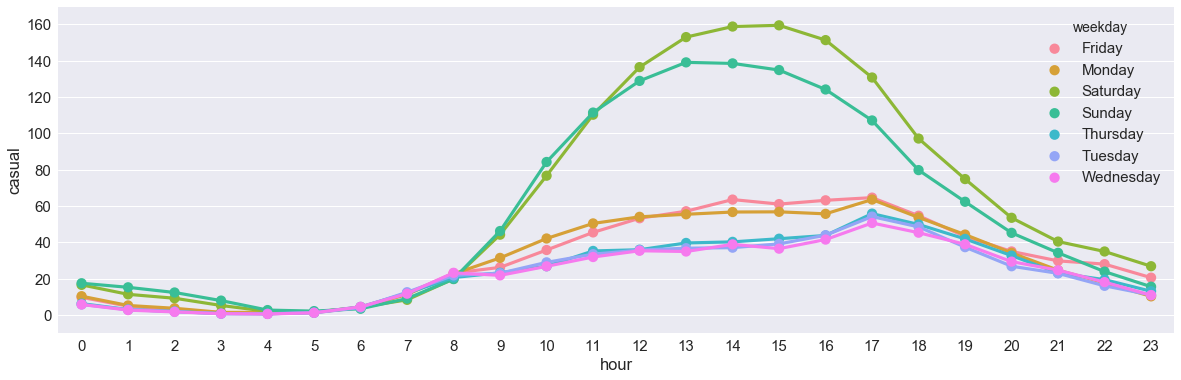

In [22]:
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1.5)
groupby_weekday_hour = pd.DataFrame(train_dataset.groupby(["weekday","hour"])["casual"].mean()).reset_index()
f, ax = plt.subplots(figsize=(20, 6))
sns.pointplot(data=groupby_weekday_hour,x="hour",y="casual" ,hue ="weekday" ,ax=ax  ,join=True)
sns.despine()

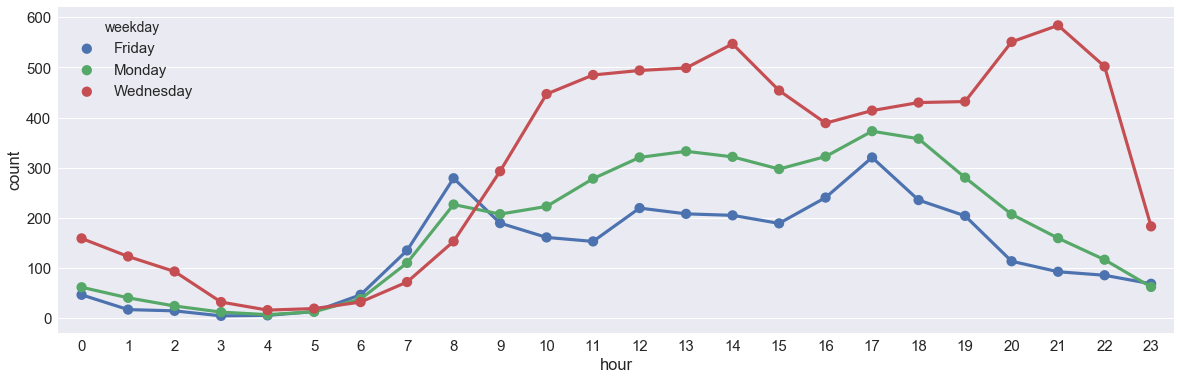

In [23]:
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1.5)
groupby_holiday_hour = pd.DataFrame(train_dataset[train_dataset["holiday"]==1].groupby(["weekday","hour"])["count"].mean()).reset_index()
f, ax = plt.subplots(figsize=(20, 6))
sns.pointplot(data=groupby_holiday_hour,x="hour",y="count" ,hue ="weekday" ,ax=ax  ,join=True)
sns.despine()

#### Inferences
###### Across all seasons  we can observe difference  in bike sharing demand on working days and  non working days

---  
### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection & Engineering
#### create daytype  feature to classify working day,weekend,holiday
#### create peakhour feature classified as low ,high,average  
#### c) Data Transforms

In [24]:
def day_type(row):
    if (row['holiday'] ==0) and (row['workingday'] ==0) :
        return  "weekend"
    if (row['holiday']==1):
        return "holiday"
    if (row['holiday'] ==0) and (row['workingday'] ==1) :
        return "workingday"
    
train_dataset["daytype"] =train_dataset.apply(day_type,axis=1)
test_dataset["daytype"] =test_dataset.apply(day_type,axis=1)

In [25]:
def get_weekend(row):
    if (row['weekday'] =='Saturday') or (row['weekday'] =='Sunday') :
        return 1
    else :
        return 0
    
train_dataset["weekend"] =train_dataset.apply(get_weekend,axis=1)
test_dataset["weekend"] =test_dataset.apply(get_weekend,axis=1)      
    

In [26]:
'''
def peak_hour(row):
    if (row['daytype']=="holiday"):
        return "notdefined"
    if ((row['daytype']=="workingday") && ):
'''

'\ndef peak_hour(row):\n    if (row[\'daytype\']=="holiday"):\n        return "notdefined"\n    if ((row[\'daytype\']=="workingday") && ):\n'

In [27]:
train_dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,datetime_tmp,year,month,day,hour,minute,weekday,log_count,daytype,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,2011-01-01 00:00:00,2011,January,1,0,0,Saturday,2.7726,weekend,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,2011-01-01 01:00:00,2011,January,1,1,0,Saturday,3.6889,weekend,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,2011-01-01 02:00:00,2011,January,1,2,0,Saturday,3.4657,weekend,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,2011-01-01 03:00:00,2011,January,1,3,0,Saturday,2.5649,weekend,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,2011-01-01 04:00:00,2011,January,1,4,0,Saturday,0.0000,weekend,1


In [28]:
### Windspeed is zero for lot rows.we will use Random forest classifier  to  fill in the missing values
train_dataset[train_dataset['windspeed']==0]['windspeed'].count()

1313

In [29]:
train_dataset[~(train_dataset['windspeed']==0)]['windspeed'].count()

9573

In [30]:
full_dataset = train_dataset.append(test_dataset)
weekday_mapper = {
 'Sunday':1,
 'Monday':2,
 'Tuesday':3,
 'Wednesday':4,
 'Thursday':5,
 'Friday':6,
 'Saturday':7
   }
month_mapper = {
 'January':1,
 'February':2,
 'March':3,
 'April':4,
 'May':5,
 'June':6,
 'July':7,
 'August':8,
 'September':9,
 'October':10,
 'November':11,
 'December' :12 
   }
full_dataset["month"].replace(month_mapper,inplace=True) 
full_dataset["weekday"].replace(weekday_mapper,inplace=True) 
full_dataset.head()

,atemp,casual,count,datetime,datetime_tmp,day,daytype,holiday,hour,humidity,...,month,registered,season,temp,weather,weekday,weekend,windspeed,workingday,year
0,14.395,3.0,16.0,2011-01-01 00:00:00,2011-01-01 00:00:00,1,weekend,0,0,81,...,1,13.0,1,9.84,1,7,1,0.0,0,2011
1,13.635,8.0,40.0,2011-01-01 01:00:00,2011-01-01 01:00:00,1,weekend,0,1,80,...,1,32.0,1,9.02,1,7,1,0.0,0,2011
2,13.635,5.0,32.0,2011-01-01 02:00:00,2011-01-01 02:00:00,1,weekend,0,2,80,...,1,27.0,1,9.02,1,7,1,0.0,0,2011
3,14.395,3.0,13.0,2011-01-01 03:00:00,2011-01-01 03:00:00,1,weekend,0,3,75,...,1,10.0,1,9.84,1,7,1,0.0,0,2011
4,14.395,0.0,1.0,2011-01-01 04:00:00,2011-01-01 04:00:00,1,weekend,0,4,75,...,1,1.0,1,9.84,1,7,1,0.0,0,2011


In [31]:
from sklearn.ensemble import RandomForestClassifier

wind_features = ["season","weather","humidity","month","temp","year","atemp"]
wind_zero_ds =full_dataset[full_dataset['windspeed']==0]
wind_nonzero_ds =full_dataset[full_dataset['windspeed']!=0]
wind_nonzero_ds["windspeed"] = wind_nonzero_ds["windspeed"].astype("str")

wind_rfc = RandomForestClassifier()
wind_rfc.fit(wind_nonzero_ds[wind_features],wind_nonzero_ds["windspeed"])
wind_values = wind_rfc.predict(wind_zero_ds[wind_features])
wind_zero_ds["windspeed"] =wind_values

full_dataset = wind_nonzero_ds.append(wind_zero_ds)
full_dataset["windspeed"] = full_dataset["windspeed"].astype("float")
full_dataset.reset_index(inplace=True)
full_dataset.drop('index',inplace=True,axis=1)

F:\Anaconda2\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\Anaconda2\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [32]:
full_dataset[full_dataset['windspeed']==0]['windspeed'].count()

0

In [33]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 22 columns):
atemp           17379 non-null float64
casual          10886 non-null float64
count           10886 non-null float64
datetime        17379 non-null object
datetime_tmp    17379 non-null datetime64[ns]
day             17379 non-null int64
daytype         17379 non-null object
holiday         17379 non-null int64
hour            17379 non-null int64
humidity        17379 non-null int64
log_count       10886 non-null float64
minute          17379 non-null int64
month           17379 non-null int64
registered      10886 non-null float64
season          17379 non-null int64
temp            17379 non-null float64
weather         17379 non-null int64
weekday         17379 non-null int64
weekend         17379 non-null int64
windspeed       17379 non-null float64
workingday      17379 non-null int64
year            17379 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(12), ob

In [34]:
category_features = ["season","holiday","workingday","weather","weekday","month","year","hour","weekend","daytype"]
continuous_features = ["temp","humidity","windspeed","atemp"]
drop_features = ['day','casual',"log_count","count","datetime","datetime_tmp","registered"]


for var in category_features:
    full_dataset[var] = full_dataset[var].astype("category")
    


In [35]:
from sklearn import feature_extraction
def one_hot_dataframe(data,columns,replace=False):
    fe_vec= feature_extraction.DictVectorizer()
    make_dict = lambda row :dict((column,row[column]) for column in  columns)
    vector_data=pd.DataFrame(fe_vec.fit_transform( data[columns].apply(make_dict, axis=1)).toarray())
    vector_data.columns = fe_vec.get_feature_names()
    vector_data.index= data.index
    if replace:
        data = data.drop(columns, axis=1)
        data = data.join(vector_data)
    return data,vector_data

In [36]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, ['daytype'], replace=True)

In [37]:
train_dataset = full_dataset[(full_dataset['count'].isnull()==False)]
test_dataset  = full_dataset[(full_dataset['count'].isnull()==True)]

In [38]:
train_y = train_dataset['count']
train_X = train_dataset.drop(drop_features,axis=1)
test_X = test_dataset.drop(drop_features,axis=1)

In [40]:
train_X.head()

,atemp,holiday,hour,humidity,minute,month,season,temp,weather,weekday,weekend,windspeed,workingday,year,daytype=holiday,daytype=weekend,daytype=workingday
0,12.880,0,5,75,0,1,1,9.84,2,7,1,6.0032,0,2011,0.0,1.0,0.0
1,19.695,0,10,76,0,1,1,15.58,1,7,1,16.9979,0,2011,0.0,1.0,0.0
2,16.665,0,11,81,0,1,1,14.76,1,7,1,19.0012,0,2011,0.0,1.0,0.0
3,21.210,0,12,77,0,1,1,17.22,1,7,1,19.0012,0,2011,0.0,1.0,0.0
4,22.725,0,13,72,0,1,1,18.86,2,7,1,19.9995,0,2011,0.0,1.0,0.0


In [41]:
test_X.head()

,atemp,holiday,hour,humidity,minute,month,season,temp,weather,weekday,weekend,windspeed,workingday,year,daytype=holiday,daytype=weekend,daytype=workingday
9573,11.365,0,0,56,0,1,1,10.66,1,5,0,26.0027,1,2011,0.0,0.0,1.0
9574,12.880,0,3,56,0,1,1,10.66,1,5,0,11.0014,1,2011,0.0,0.0,1.0
9575,12.880,0,4,56,0,1,1,10.66,1,5,0,11.0014,1,2011,0.0,0.0,1.0
9576,11.365,0,5,60,0,1,1,9.84,1,5,0,15.0013,1,2011,0.0,0.0,1.0
9577,10.605,0,6,60,0,1,1,9.02,1,5,0,15.0013,1,2011,0.0,0.0,1.0


In [42]:
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

In [43]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [55]:
from sklearn.model_selection  import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
test_size = 0.33
seed = 7

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)


In [58]:
from sklearn.linear_model  import Ridge,RidgeCV
from sklearn.preprocessing import StandardScaler

regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0],cv=10)
model_cv = regr_cv.fit(X_trainmodel,y = np.log1p(y_trainmodel))
y_pred= model_cv.predict(X= X_val)
print ("RMSLE Value For Ridge: ",rmsle(np.exp(np.log1p(y_val)),np.exp(y_pred),False))

alphas = np.array([10,1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)

model = Ridge()
gridRidge = GridSearchCV(estimator=model, param_grid=param_grid)

gridRidge.fit(X=X_trainmodel, y = np.log1p(y_trainmodel))

print(gridRidge.best_score_)
print(gridRidge.best_params_)
y_pred= gridRidge.predict(X= X_val)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_val)),np.exp(y_pred),False))
#y_pred_test = gridRidge.predict(X=test_X)


RMSLE Value For Ridge:  0.973881919447
0.487059596999
{'alpha': 10.0}
RMSLE Value For Random Forest:  0.973881919447


In [59]:
from sklearn.ensemble import RandomForestRegressor


rfreg_model = RandomForestRegressor(n_estimators=300) ### Test 0.44
rfreg_model.fit(X = X_trainmodel,y = np.log1p(y_trainmodel))
y_pred= rfreg_model.predict(X= X_val)

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_val)),np.exp(y_pred),False))

RMSLE Value For Random Forest:  0.287931081135


In [ ]:
'''
param_grid = {"n_estimators": [500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10]
             }

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)

grid.fit(X=X_trainmodel, y = np.log1p(y_trainmodel))

print(grid.best_score_)
print(grid.best_params_
y_pred= grid.predict(X= X_val)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_val)),np.exp(y_pred),False))
y_pred_test = grid.predict(X=test_X)
'''

In [60]:
rfreg_model = RandomForestRegressor(max_depth= None, min_samples_leaf=1, n_estimators= 500, min_samples_split=2,max_features= 10) 

rfreg_model.fit(X = X_trainmodel,y = np.log1p(y_trainmodel))
y_pred= rfreg_model.predict(X= X_val)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_val)),np.exp(y_pred),False))

RMSLE Value For Random Forest:  0.288014962636


In [61]:
y_pred_test = rfreg_model.predict(X=test_X)

In [62]:
submission = pd.DataFrame({
        "datetime": test_dataset["datetime"],
        "count": [max(0, x) for x in np.exp(y_pred_test)]
    })
submission.to_csv('bike_prediction_output.csv', index=False)